In [115]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


In [116]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

In [117]:
print(data[:2, :])
print(len(data))

[[6. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]]
20000


In [118]:
labelsT = torch.tensor(data[:, 0]).long()
data = data[:, 1:]
dataNorm = data/np.max(data)
print(dataNorm.shape)
datat = torch.tensor(dataNorm).float()
print(datat.size())
print(datat[:2])
dataT = datat.reshape(-1, 1,  28, 28)
print(dataT.shape)

(20000, 784)
torch.Size([20000, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([20000, 1, 28, 28])


In [119]:
print(dataT[:2])

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


In [120]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, shuffle = True, test_size = 0.1)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchSize = 32
train_loader = DataLoader(train_data, batch_size = batchSize, drop_last = True, shuffle = True )
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0]) 

In [121]:
print(train_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[0].shape)


torch.Size([18000, 1, 28, 28])
torch.Size([2000, 1, 28, 28])


In [122]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])

trainset = torchvision.datasets.FashionMNIST(root= './data', train=True, transform = transform, download=True)
testset = torchvision.datasets.FashionMNIST(root= './data', train=False, transform = transform, download=True)
batchSize = 32
fmnist_train_loader = DataLoader(trainset, batch_size = batchSize, shuffle = True, drop_last = True)
fmnist_test_loader = DataLoader(testset, batch_size = testset.data.shape[0])

In [123]:
print(fmnist_train_loader.dataset.data.shape)
print(fmnist_test_loader.dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [124]:
print(fmnist_train_loader.dataset.classes)
print(fmnist_train_loader.dataset.targets)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
tensor([9, 0, 0,  ..., 3, 0, 5])


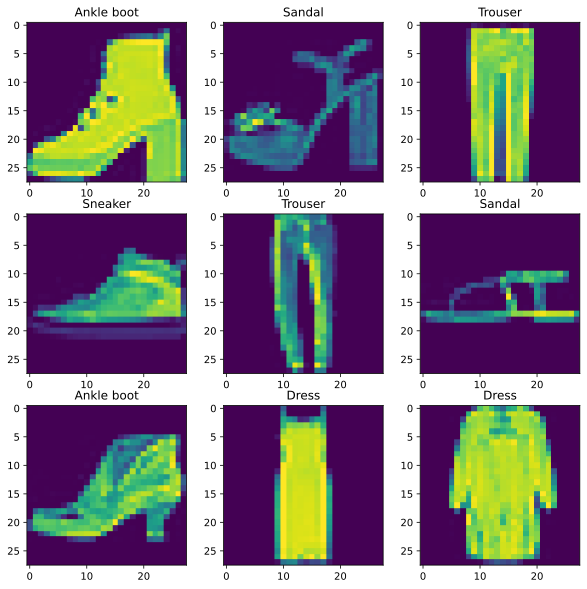

In [125]:
fig, axs = plt.subplots(3, 3, figsize = (10, 10))

for idx, ax in enumerate(axs.flatten()):
  randindx = np.random.choice(trainset.data.shape[0])
  ax.imshow(fmnist_train_loader.dataset.data[randindx])
  ax.set_title(fmnist_train_loader.dataset.classes[fmnist_train_loader.dataset.targets[randindx]])

plt.show()


In [113]:
def createTheMnistnet(printtoggle = False):
  class MnistNet(nn.Module):
    def __init__(self, printoggle):
      super().__init__()
      self.print = printtoggle

      self.conv1 = nn.Conv2d(1, 10, 5, stride = 1, padding = 1)
      # output = np.floor((28 + 1*2 - 5)/ 1) + 1 = 26/2 = 13

      self.conv2 = nn.Conv2d(10, 20, kernel_size = 5, stride = 1, padding = 1)
      # output = np.floor((13 + 1*2 - 5)/1) + 1 = 11/2 = 5

      self.fc1 = nn.Linear(20*5*5, 50)
      self.output = nn.Linear(50, 10)

    def forward(self, x):
      if self.print: print(f'Input size: {x.shape}')
      x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
      print(f'Layer 1 conv: {x.shape}') if self.print else None

      x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
      print(f'Layer 2 conv: {x.shape}') if self.print else None

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1, int(nUnits))

      x = F.relu(self.fc1(x))
      print(f'Layer fc1: {x.shape} ') if self.print else None

      x = F.relu(self.output(x))
      print(f'Layer output: {x.shape} ') if self.print else None

      return x

  net = MnistNet(printtoggle)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr = 0.005)

  return net, lossfun, optimizer

In [114]:
net, lossfun, optimizer = createTheMnistnet(True)
X, y = next(iter(train_loader))

yHat = net(X)
print(yHat.shape)
print(y.shape)
print(yHat[:2], y[:2])
loss = lossfun(yHat, torch.squeeze(y))
print(f'Loss: {loss}')

Input size: torch.Size([32, 1, 28, 28])
Layer 1 conv: torch.Size([32, 10, 13, 13])
Layer 2 conv: torch.Size([32, 20, 5, 5])
Layer fc1: torch.Size([32, 50]) 
Layer output: torch.Size([32, 10]) 
torch.Size([32, 10])
torch.Size([32])
tensor([[0.1044, 0.0000, 0.1080, 0.0000, 0.0000, 0.0911, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1074, 0.0000, 0.1288, 0.0000, 0.0000, 0.0883, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<SliceBackward0>) tensor([8, 5])
Loss: 2.3063671588897705


In [129]:
from torchsummary import summary
summary(net, (1, 28, 28))

Input size: torch.Size([2, 1, 28, 28])
Layer 1 conv: torch.Size([2, 10, 13, 13])
Layer 2 conv: torch.Size([2, 20, 5, 5])
Layer fc1: torch.Size([2, 50]) 
Layer output: torch.Size([2, 10]) 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [135]:
def function2trainTheModel():

  numepochs = 10
  net, lossfun, optimizer = createTheMnistnet()

  trainAcc = torch.zeros(numepochs)
  testAcc = torch.zeros(numepochs)
  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)

  for epoch in range(numepochs):
    net.train()
    batchLoss = []
    batchAcc = []

    for X, y in train_loader:

      yHat = net(X)
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())
      matches = (torch.argmax(yHat, axis = 1) == y).float()
      accuracy = torch.mean(matches).item()
      batchAcc.append(accuracy)
    
    trainAcc[epoch] = 100 * np.mean(batchAcc)
    trainLoss[epoch] = np.mean(batchLoss)

    net.eval()
    X, y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat, y)

    testLoss[epoch] = loss.item()
    testAcc[epoch] = 100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item()
  

  return trainAcc, testAcc, trainLoss, testLoss, net


In [136]:
trainAcc, testAcc, trainLoss, testLoss, net = function2trainTheModel()

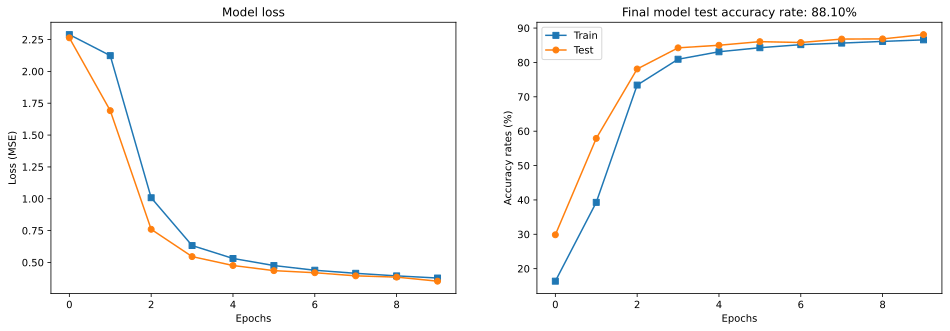

In [137]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy rates (%)')
ax[1].set_title(f'Final model test accuracy rate: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [138]:
X, y = next(iter(fmnist_test_loader))
yHat = net(X)
acc = 100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item()
print(f'Fmnist accuracy: {acc:.2f}')

Fmnist accuracy: 6.01


In [144]:
for target, source in net.named_parameters():
  print(target.data)

AttributeError: ignored

In [148]:
fashionNet,lossfun,optimizer = createTheMnistnet()
print( fashionNet.conv1.weight[0] - net.conv1.weight[0] )

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(fashionNet.named_parameters(),net.named_parameters()):
  print(target[0])
  target[1].data = copy.deepcopy( source[1].data )

print( fashionNet.conv1.weight[0] - net.conv1.weight[0] )

tensor([[[-0.4242, -0.1217, -0.3652,  0.1938,  0.2438],
         [-0.0709, -0.0397, -0.4000,  0.0107, -0.1777],
         [-0.0673, -0.0868, -0.1761, -0.1001, -0.2971],
         [-0.0630,  0.0487, -0.0997, -0.1963, -0.2011],
         [ 0.0249,  0.0219, -0.1373, -0.1916,  0.0365]]],
       grad_fn=<SubBackward0>)
conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
output.weight
output.bias
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], grad_fn=<SubBackward0>)
